# **Setup**

In [1]:
!pip install -q tensorflow-gpu

     |████████████████████████████████| 458.3 MB 12 kB/s 


In [2]:
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Dense, LSTM

# **Predição da Série Temporal em Análise**

## **Série Temporal em Análise**

In [268]:
beta = 1
n = np.arange(0, 400, 1)
v_n = np.random.normal(scale=0.5, size=len(n))
v_n_1 = np.random.normal(scale=0.5, size=len(n-1))
v_n_2 = np.random.normal(scale=0.5, size=len(n-2)) 
x = v_n + beta*v_n_1*v_n_2  

No handles with labels found to put in legend.


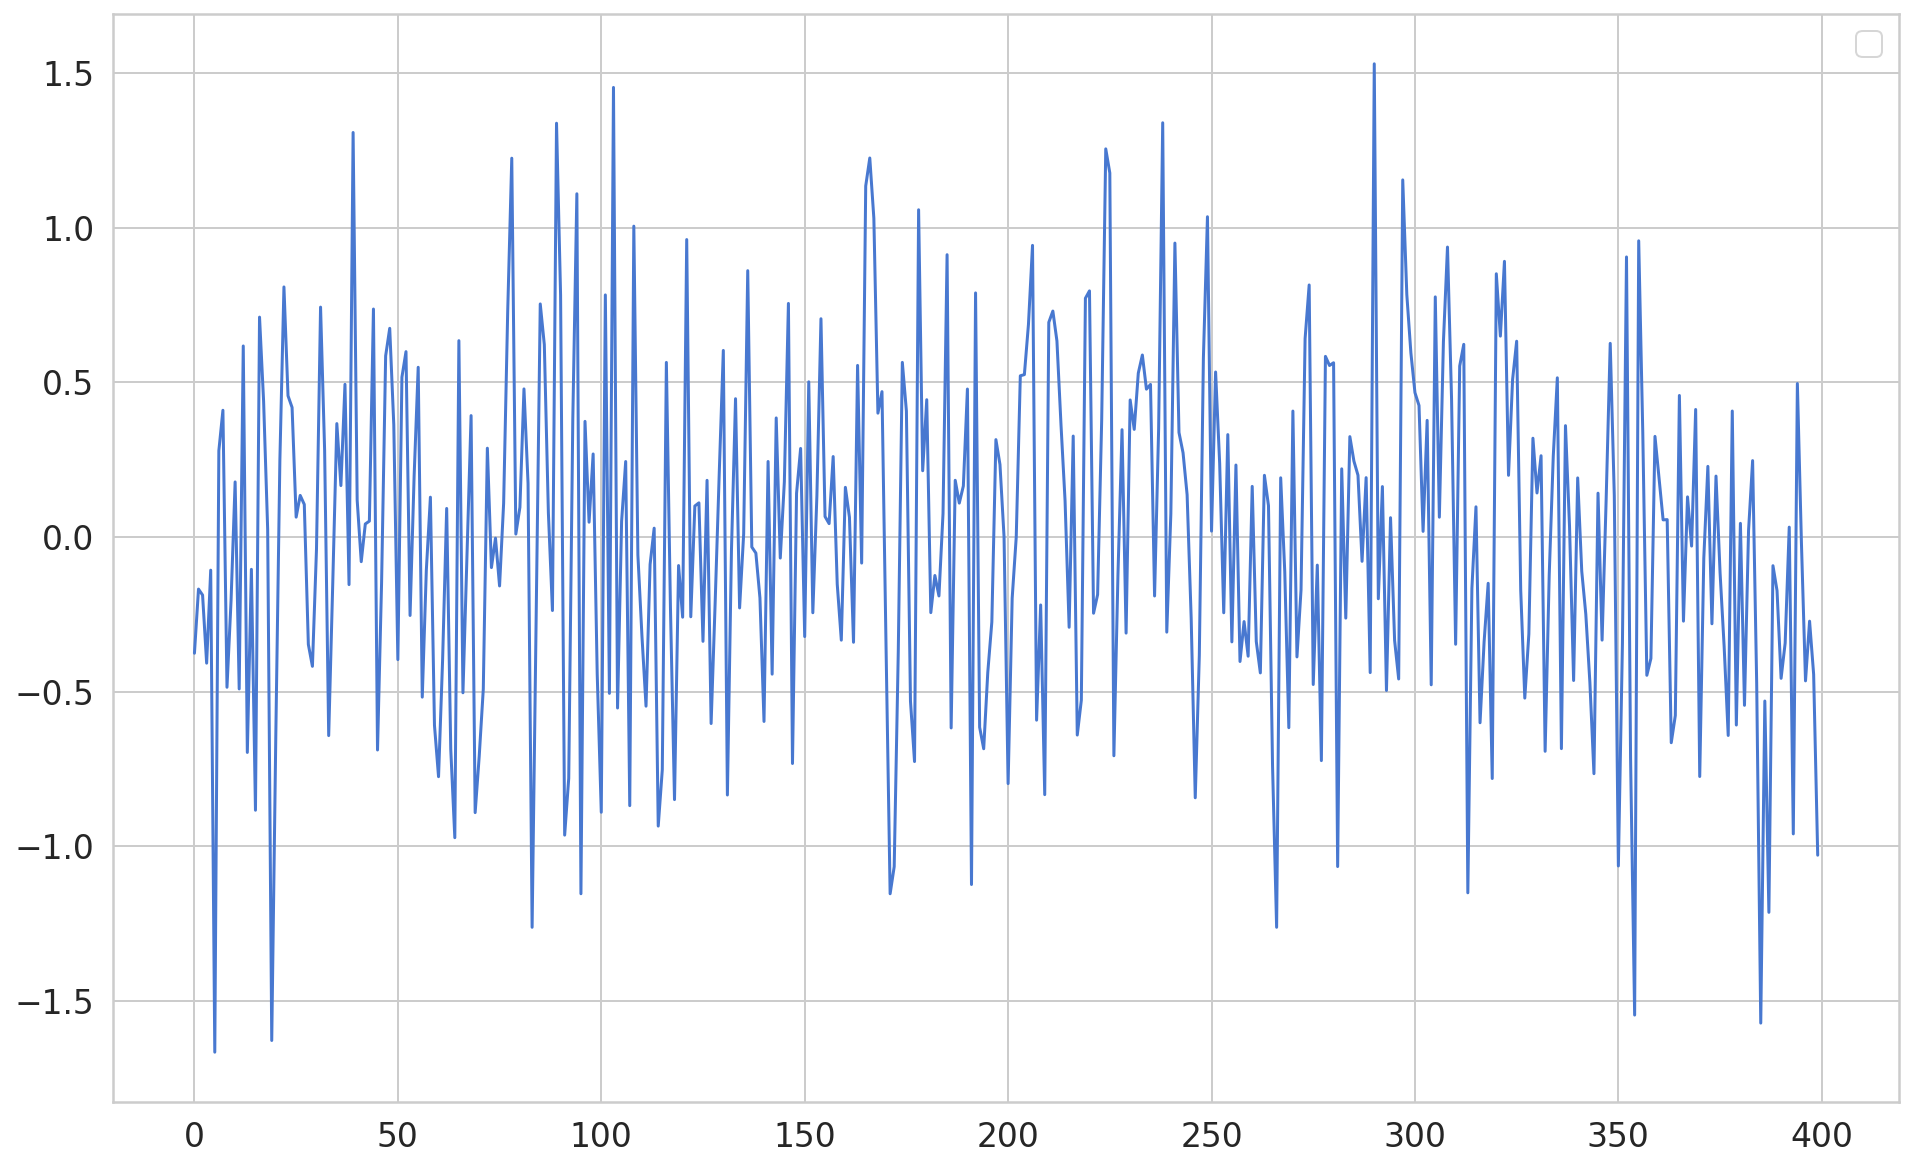

In [269]:
plt.plot(n, x)
plt.legend();   

## **Data Preprocessing**

In [270]:
df = pd.DataFrame(dict(X_x=x), index=n, columns=['X_x'])
df.head()

,X_x
0,-0.376220
1,-0.168726
2,-0.188098
3,-0.408242
4,-0.107517


In [271]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

380 20


In [272]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [273]:
time_steps = 10
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.X_x, time_steps)
X_test, y_test = create_dataset(test, test.X_x, time_steps)
print(X_train.shape, y_train.shape)

(370, 10, 1) (370,)


In [274]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [275]:
X_train[0]

array([[-0.37622013, -0.16872589, -0.18809797, -0.40824174, -0.10751741,
        -1.66624427,  0.27878148,  0.40953806, -0.48622665, -0.20637388]])

In [276]:
y_train[0]

0.17780389733152413

## **Predição da Série Temporal com LSTM**

In [277]:
inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2])) 
x = layers.Bidirectional(layers.LSTM(64,  return_sequences=False))(inputs)
#x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="linear")(x) 
model = tf.keras.Model(inputs, outputs)

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))

In [278]:
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 1, 10)]           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 128)               38400     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total params: 38,529
Trainable params: 38,529
Non-trainable params: 0
_________________________________________________________________


## **Training**

In [279]:
history = model.fit(
    np.asarray(X_train).astype('float32'),
    np.asarray(y_train).astype('float32'),
    epochs=80,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/80
21/21 [==============================] - 4s 40ms/step - loss: 0.3145 - val_loss: 0.3056
Epoch 2/80
21/21 [==============================] - 0s 4ms/step - loss: 0.3066 - val_loss: 0.3049
Epoch 3/80
21/21 [==============================] - 0s 4ms/step - loss: 0.3041 - val_loss: 0.3033
Epoch 4/80
21/21 [==============================] - 0s 4ms/step - loss: 0.3027 - val_loss: 0.3014
Epoch 5/80
21/21 [==============================] - 0s 5ms/step - loss: 0.3017 - val_loss: 0.2997
Epoch 6/80
21/21 [==============================] - 0s 4ms/step - loss: 0.3008 - val_loss: 0.2985
Epoch 7/80
21/21 [==============================] - 0s 4ms/step - loss: 0.3000 - val_loss: 0.2977
Epoch 8/80
21/21 [==============================] - 0s 5ms/step - loss: 0.2991 - val_loss: 0.2972
Epoch 9/80
21/21 [==============================] - 0s 5ms/step - loss: 0.2983 - val_loss: 0.2969
Epoch 10/80
21/21 [==============================] - 0s 4ms/step - loss: 0.2975 - val_loss: 0.2968
Epoch 11/80
21/21 

## **Evaluation**

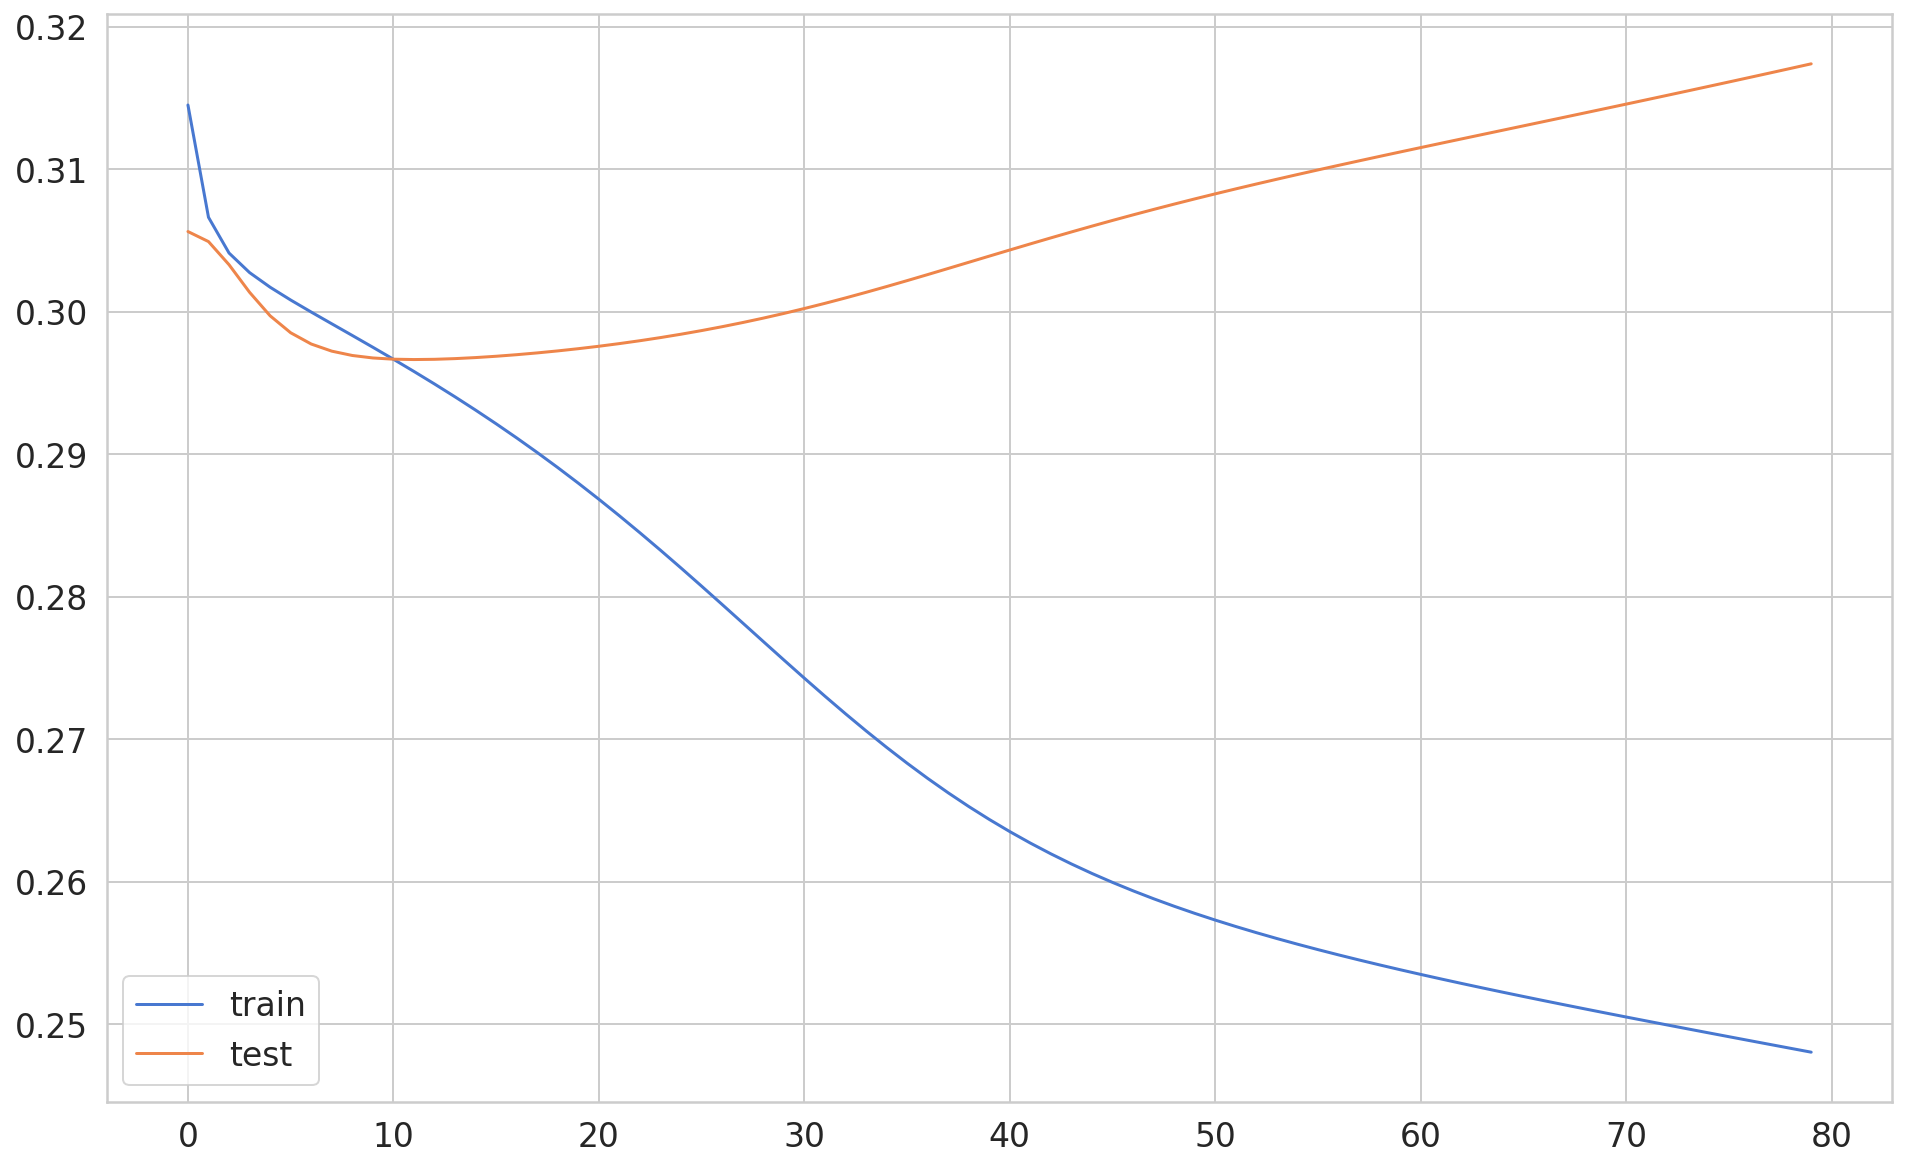

In [281]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [282]:
y_pred = model.predict(np.asarray(X_test).astype('float32'))

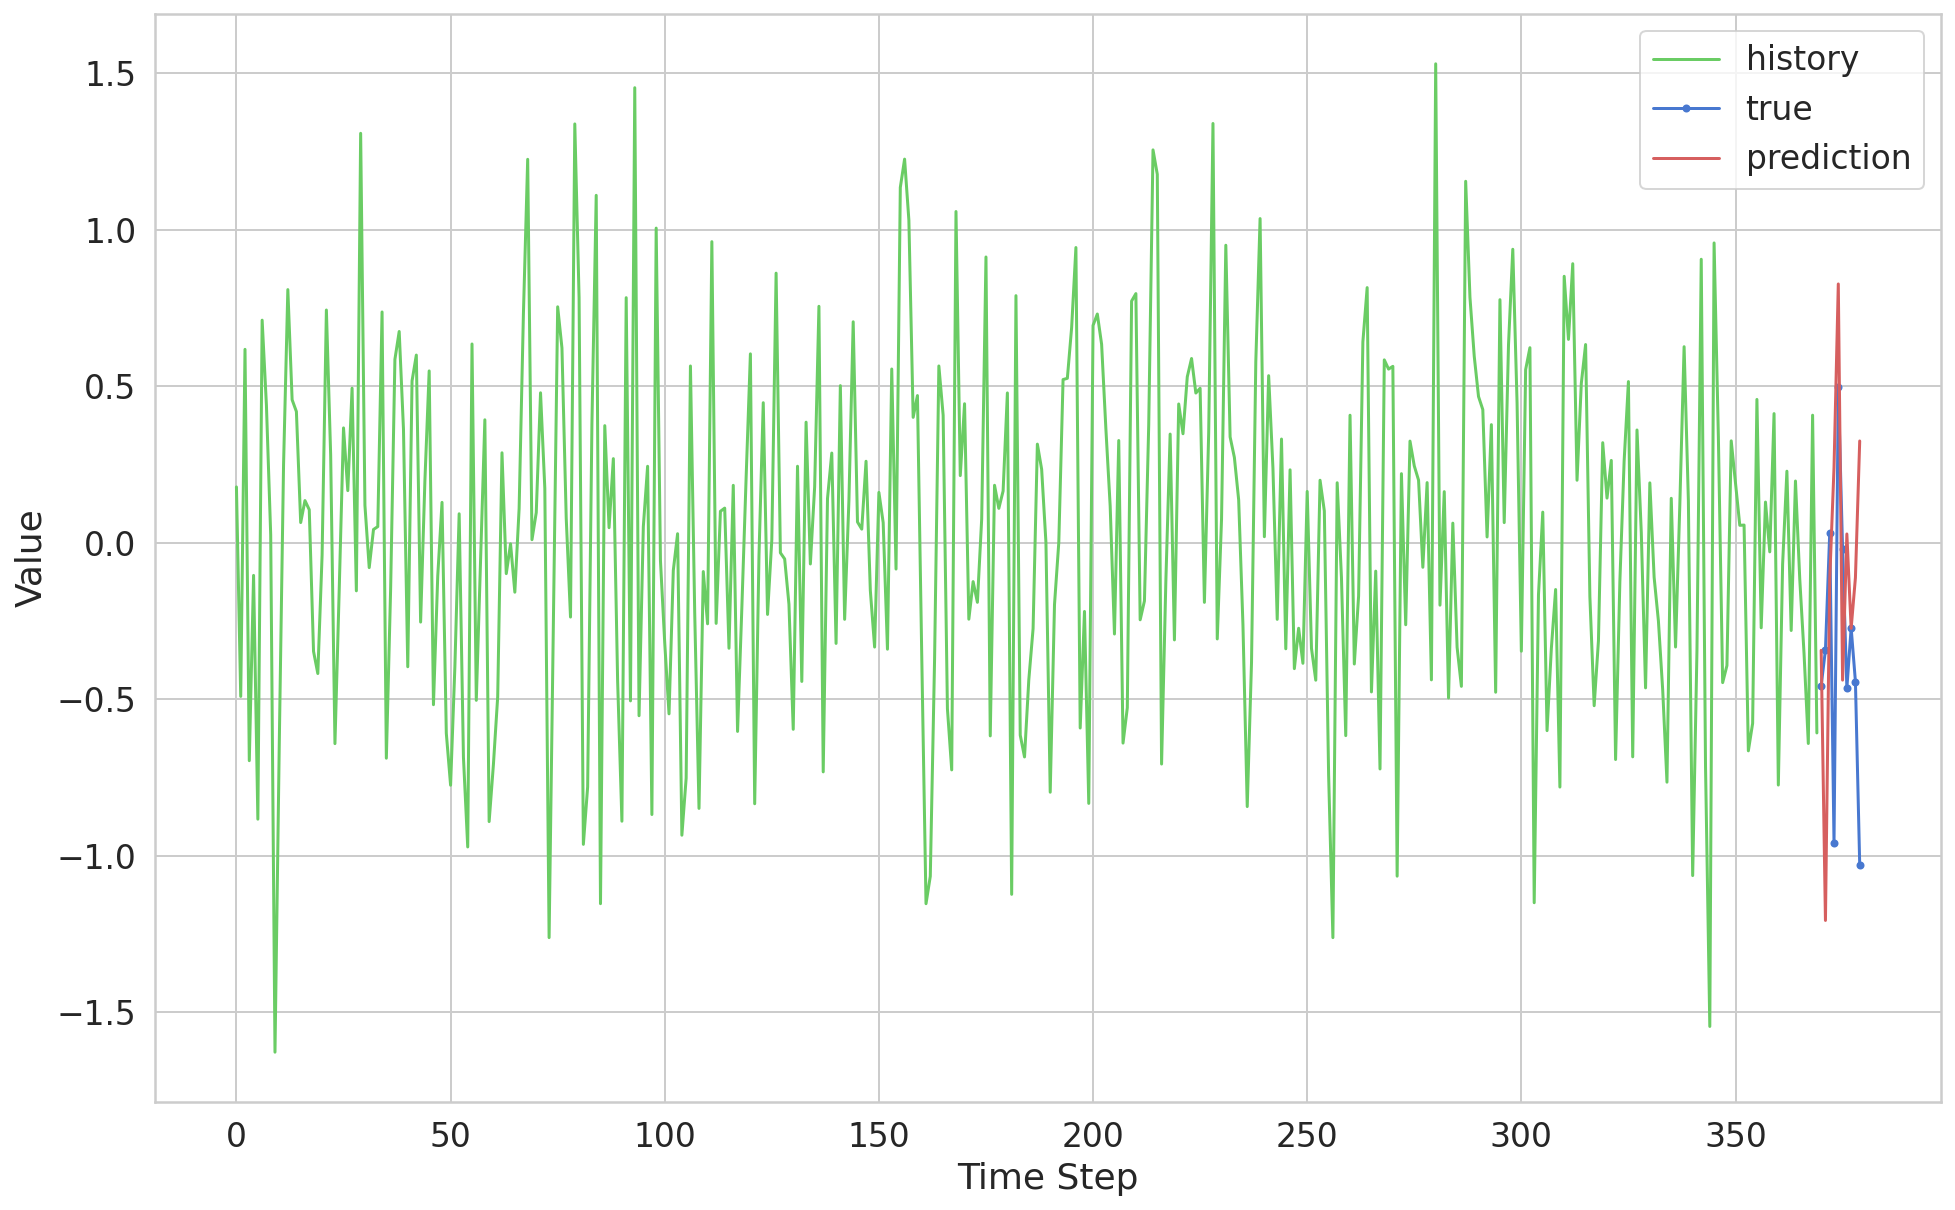

In [283]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

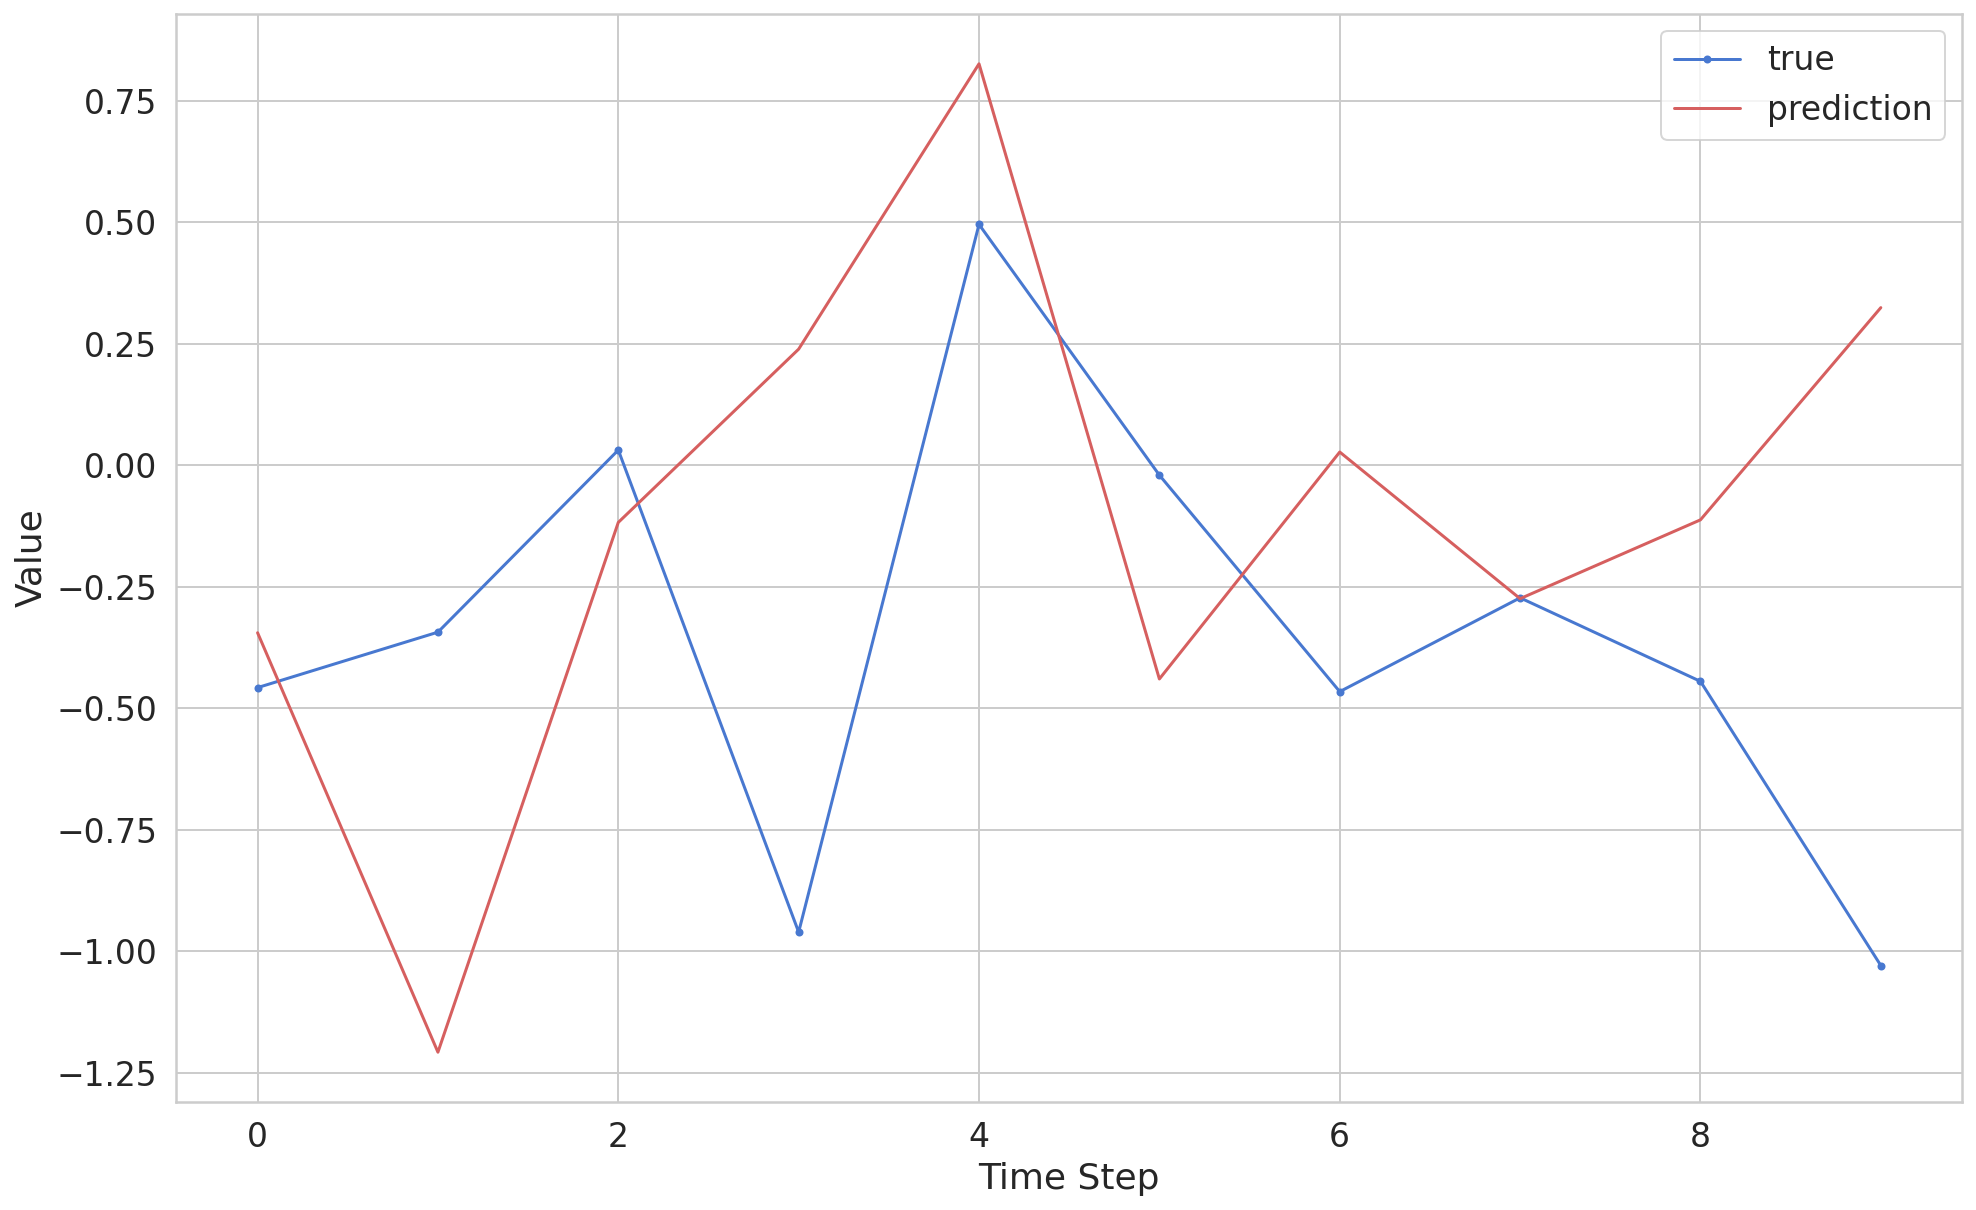

In [284]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();